
Conjuntos de datos y cargadores de datos
------------------------

A continuación, vamos a demostrar cómo usar uno de los archivos listos para descargar,
 conjuntos de datos de acceso abierto de TorchVision, cómo transformar las imágenes para
 consumo por su modelo, y cómo usar el DataLoader para alimentar lotes
 de datos a su modelo.

 Lo primero que tenemos que hacer es transformar nuestras imágenes entrantes en un
 Tensor PyTorch.

In [1]:
#%matplotlib inline

import torch
import torchvision
import torchvision.transforms as transforms

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

Aquí, especificamos dos transformaciones para nuestra entrada:

 - ``transforms.ToTensor()`` convierte las imágenes cargadas por Pillow en 
    Tensores PyTorch.
 - ``transforms.Normalize()`` ajusta los valores del tensor para que
    que su promedio es cero y su desviación estándar es 0.5.  La mayoría
    Las funciones de activación tienen sus gradientes más fuertes alrededor de x = 0, por lo que
    centrar nuestros datos allí puede acelerar el aprendizaje.

 Hay muchas más transformaciones disponibles, que incluyen recortar, centrar,
 rotación y reflexión.

 A continuación, crearemos una instancia del conjunto de datos CIFAR10.  Este es un conjunto de
 Mosaicos de imágenes en color de 32x32 que representan 10 clases de objetos: 6 de animales
 (pájaro, gato, venado, perro, rana, caballo) y 4 de vehículos (avión,
 automóvil, barco, camión):

In [ ]:
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)

<div class="alert alert-info"><h4>Nota</h4><p>Cuando ejecuta la celda de arriba, puede tomar un poco de tiempo para el 
      conjunto de datos para descargar.</p></div>

 Este es un ejemplo de creación de un objeto de conjunto de datos en PyTorch.  Descargable
 conjuntos de datos (como CIFAR-10 arriba) son subclases de
 ``torch.utils.data.Dataset``.  Las clases ``Dataset`` en PyTorch incluyen el
 conjuntos de datos descargables en TorchVision, Torchtext y TorchAudio, así como
 como clases de conjuntos de datos de utilidad como ``torchvision.datasets.ImageFolder``,
 que leerá una carpeta de imágenes etiquetadas.  Tu también puedes crear el tuyo
 subclases de ``Dataset``.

 Cuando creamos una instancia de nuestro conjunto de datos, debemos decirle algunas cosas:

 - La ruta del sistema de archivos a donde queremos que vayan los datos. 
 - Si estamos utilizando o no este conjunto para el entrenamiento;  la mayoría de los conjuntos de datos
    se dividirá en subconjuntos de entrenamiento y prueba.
 - Si nos gustaría descargar el conjunto de datos si aún no lo hemos hecho.
 - Las transformaciones que queremos aplicar a los datos.

 Una vez que su conjunto de datos esté listo, puede dárselo al ``DataLoader``:

In [3]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

Una subclase ``Dataset`` envuelve el acceso a los datos y está especializada en
 el tipo de datos que está sirviendo.  El ``DataLoader`` no sabe *nada* sobre
 los datos, pero organiza los tensores de entrada servidos por el ``Conjunto de datos`` en
 lotes con los parámetros que especifique.

 En el ejemplo anterior, le hemos pedido a un ``DataLoader`` que nos dé lotes de
 4 imágenes de ``trainset``, aleatorizando su orden (``shuffle=True``),
 y le dijimos que activara dos trabajadores para cargar datos desde el disco.


  car   dog  frog   dog


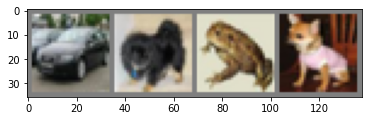

In [4]:
import matplotlib.pyplot as plt
import numpy as np

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

Ejecutar la celda anterior debería mostrarle una tira de cuatro imágenes, y el
 etiqueta correcta para cada uno.

 Entrenamiento de su modelo PyTorch
 ---------------------------

 Juntemos todas las piezas y entrenemos un modelo:

In [5]:
#%matplotlib inline

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torchvision
import torchvision.transforms as transforms

import matplotlib
import matplotlib.pyplot as plt
import numpy as np

Primero, necesitaremos conjuntos de datos de entrenamiento y prueba.  Si aún no lo has hecho,
 ejecute la celda a continuación para asegurarse de que se descargue el conjunto de datos.  (Se puede tomar
 un minuto.)

In [6]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


Ejecutaremos nuestra verificación en la salida de ``DataLoader``:

  car horse  deer  deer


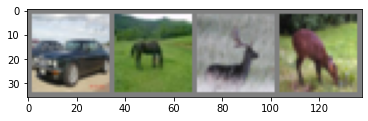

In [7]:
# functions to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [8]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


Net = Net()

Los últimos ingredientes que necesitamos son una función de pérdida y un optimizador:

In [10]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(Net.parameters(), lr=0.001, momentum=0.9)

Este es el modelo que entrenaremos.  Si te resulta familiar, es porque es
 una variante de LeNet, discutida anteriormente en este video, adaptada para
 Imágenes de 3 colores.

In [11]:
for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = Net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 2.137
[1,  4000] loss: 1.871
[1,  6000] loss: 1.679
[1,  8000] loss: 1.584
[1, 10000] loss: 1.506
[1, 12000] loss: 1.479
[2,  2000] loss: 1.407
[2,  4000] loss: 1.368
[2,  6000] loss: 1.341
[2,  8000] loss: 1.313
[2, 10000] loss: 1.284
[2, 12000] loss: 1.305
Finished Training


Aquí, estamos haciendo solo **2 épocas de entrenamiento** (línea 1), es decir, dos
 pasa sobre el conjunto de datos de entrenamiento.  Cada pasada tiene un lazo interior que
 **itera sobre los datos de entrenamiento** (línea 4), sirviendo lotes de
 imágenes de entrada transformadas y sus etiquetas correctas.

 **Poner a cero los gradientes** (línea 9) es un paso importante.  Los gradientes son
 acumulado en un lote;  si no los reseteamos para cada lote, ellos
 seguirá acumulándose, lo que proporcionará valores de gradiente incorrectos,
 haciendo imposible el aprendizaje.

 En la línea 12, **preguntamos al modelo por sus predicciones** sobre este lote.  En
 la siguiente línea (13), calculamos la pérdida - la diferencia entre
 ``salidas`` (la predicción del modelo) y ``etiquetas`` (la salida correcta).

 En la línea 14, hacemos el pase ``hacia atrás()`` y calculamos los gradientes
 que dirigirá el aprendizaje.

 En la línea 15, el optimizador realiza un paso de aprendizaje: utiliza el
 gradientes de la llamada ``backward()`` para empujar los pesos de aprendizaje en
 la dirección que cree que reducirá la pérdida.

 El resto del bucle hace algunos informes ligeros sobre el número de época,
 cuántas instancias de capacitación se han completado y cuáles son los datos recopilados
 la pérdida es sobre el ciclo de entrenamiento.

 **Cuando ejecuta la celda de arriba,** debería ver algo como esto:

 ::

    [1, 2000] pérdida: 2.235
    [1, 4000] pérdida: 1.940
    [1, 6000] pérdida: 1.713
    [1, 8000] pérdida: 1.573
    [1, 10000] pérdida: 1.507
    [1, 12000] pérdida: 1.442
    [2, 2000] pérdida: 1.378
    [2, 4000] pérdida: 1.364
    [2, 6000] pérdida: 1.349
    [2, 8000] pérdida: 1.319
    [2, 10000] pérdida: 1.284
    [2, 12000] pérdida: 1.267
    Entrenamiento terminado

 Tenga en cuenta que la pérdida es monótonamente descendente, lo que indica que nuestro
 El modelo continúa mejorando su rendimiento en el conjunto de datos de entrenamiento.

 Como paso final, debemos comprobar que el modelo realmente está haciendo
 aprendizaje *general*, y no simplemente "memorizar" el conjunto de datos.  Esto es
 llamado **sobreajuste** y generalmente indica que el conjunto de datos es demasiado
 pequeño (no hay suficientes ejemplos para el aprendizaje general), o que el modelo tiene
 más parámetros de aprendizaje de los que necesita para modelar correctamente el conjunto de datos.

 Esta es la razón por la que los conjuntos de datos se dividen en subconjuntos de entrenamiento y prueba:
 para probar la generalidad del modelo, le pedimos que haga predicciones sobre
 datos en los que no se ha entrenado:

In [12]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = Net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 54 %
